# Practical 2. From simulation to inference

At the end of this practical you should:

- Understand why coalescent simulations are useful to gain intuition about population level processes.
- Appreciate that the site frequency spectrum (SFS) is a fundamental summary of sequence variation and understand how it relates to genealogical branch lengths.
- Understand that summary statistics are the currency for comparing real data to idealized models of population processes/history and that such comparisons can be done either via analytic results or simulations.
- Know how coalescent simulations are used in approximate likelihood inference.

In [1]:
import msprime
import tskit
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline

## 2.1 The expected site frequence spectrum

This practical is based on a python tutorial developed as part of a bookchapter which is available [here](https://link.springer.com/protocol/10.1007%2F978-1-0716-0199-0_9).

<div class="alert alert-block alert-info">
    <b>PopGen:</b>

The site frequency spectrum (SFS) summarises variants by their frequency in a sample. The SFS is a fundamental summary of sequence variation in two ways:
1. It is a lossless summary of unlinked variants, in other words any summary statistic that ignores linkage is just a further summary of the SFS (e.g. pairwise genetic diversity and divergence, $F_{st}$, Tajima's $D$ can all be computed from the SFS). 
2. The SFS forms the basis of many modern population genomic methods that infer demographyic history and/or selection from sequence variation: e.g. dadi, fastsimcoal, sweepfinder, DFE-alpha ... (we will encounter some in this course).

The SFS is convenient analytically, because it only depends on the mean length and frequency of genealogical branches. For a single Wright-Fisher population of constant size, the coalescent can used to derive a simple analytic prediction for the expected SFS: $$ S_i = \theta/i $$ for $i= 1,2,...,n-1$ (see lecture 2 and <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118087"> Hudson's recent proof</a>). Analytic expressions are also possible for the SFS around the target of a hard selective sweep (see practical 5). However, most realistic models of demography and/or selection are too complex and analytic expectations for the SFS (or other summeries of genealogies) do not exist. In this practical, we will approximate the SFS using coalescence simulations.
    </div>

Let's start by considering the SFS for a single tree. Since we want to not only simulate a genealogy, but also (in a second step) mutations, we need to specify a length of sequence. Let's use `sim_ancestry` to simulate a single genealogy for a sample of $n=9$ (haploid) individuals from a Wright-Fisher population of size $N_e =10^6$. We asumme a 1kb stretch of sequence and `sim_mutations` to simulate mutations occuring on this genealogy at a rate $\mu = 10^{-9}$. These parameters correspond roughly to *Drosophila melanogaster*.

In [ ]:
simple_ts = msprime.sim_ancestry(9, ploidy=1, sequence_length=1000, random_seed = 34, population_size=1_000_000);
#note that e-9 is shorthand for *10^(-9)
ts_with_muts = msprime.sim_mutations(simple_ts, rate=1e-9, random_seed = 34)
display(SVG(ts_with_muts.draw_svg(size=(500, 500),y_axis=True)))

<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b> How many mutations are in this genealogy? Looking at the tree above, can you work out the SFS?
    
**Hint:** Typing in the name of the tree produces a useful report
</div>

In [5]:
#SOL

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can find the corresponding SFS using the <code>tskit</code> method <a href="https://tskit.dev/tskit/docs/stable/python-api.html?highlight=frequency#tskit.TreeSequence.allele_frequency_spectrum"><code>.allele_frequency_spectrum()</code></a>. The output is a numpy array. Note that the number of singletons is at position 1 not 0, i.e. <code>simple_sfs_site[1]</code>. The first (0th) and last (nth) entry of the SFS includes the counts of mutation of frequency $0$ in $n$ in the focal population (but which may vary in some other population). Since we are only considering a single population, both $0$ and $n$ types have zero counts by definition.
</div>

<div class="alert alert-block alert-success">
    <b>Exercise 2:</b> Read the documentation for <a href="https://tskit.dev/tskit/docs/stable/python-api.html?highlight=frequency#tskit.TreeSequence.allele_frequency_spectrum"><code>.allele_frequency_spectrum()</code></a>, use this method to find the SFS of your tree and store the result as a new variable <code>simple_sfs_site</code>. How many entries does the SFS have? Is it folded or not? Does the output agree with your SFS?
</div>

In [6]:
#SOL

<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b> Run <code>allele_frequency_spectrum</code> again, setting the option <code>span_normalise = False</code>. What is the difference?
</div>

In [7]:
#SOL

<div class="alert alert-block alert-info">
    <b>PopGen:</b> The SFS is a set of counts which may or may not include the invariant category. We can normalize the SFS either by the total # of sites (<code>msprime</code> does this by default) or condition on variant sites only. In this case, invariant sites are removed and we divide by the total number of variant site counts. This choice of normalisations applies to many population genetic summary statistics! 
    
The normalized SFS can be interpreted as a probability density function, i.e. it gives the probability that a randomly choosen site in the sequence is a singleton, doubleton etc.
</div>

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> it is much more efficient to <b>NOT</b> simulate mutations in the first place. Instead, we can set <code>mode=branch</code> to record the relative length of the $i_{ton}$ branch types.
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b> Run <code>allele_frequency_spectrum</code> on <code>ts_with_muts</code> again, setting the option <code>mode="branch"</code>. What is the difference? What are the units of these SFS entries?
</div>

In [ ]:
#SOL
simple_sfs_branch = 

<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b> Compare the site and branch based SFS of <code>simple_ts</code>. Why are some entries of the branch-based SFS non-zero, the corresponding entry of the mutation-based SFS is zero? What entries are zero in both versions of the SFS?
</div>

In [20]:
#SOL

So far, we have computed the SFS for individual trees under the coalescent. When using the SFS to summarize genome wide variation, we are computing an average SFS (i.e. the expectation) over many sites and genealogies. Let's use simulations to find the expectation for the average SFS.

The code chunk below sets up 10,000 replicates. As in practical 1, we use a `for` loop to populate an empty numpy array (which we have called `sfs_table`) with the SFS of each replicate. 

**Note:**

- `sfs_table` is a 2D array (check its shape to convince yourself)
- we are using the `branch` mode to compute the SFS; i.e. the simulations do not include mutations

In [19]:
num_replicates = 10_000
nsamp = 9
sfs_table = np.zeros((num_replicates, nsamp+1))
replicates = msprime.sim_ancestry(9, ploidy=1, num_replicates=num_replicates,  population_size=1_000_000, random_seed=42)
for replicate_index, ts in enumerate(replicates):
    sfs = ts.allele_frequency_spectrum(mode="branch", polarised=True)
    sfs_table[replicate_index] = sfs

We use <code>.mean()</code> to calculate the mean SFS across all replicates:

In [20]:
sfs_mean = sfs_table.mean(0)[1:nsamp]
print("The mean SFS is: \n", sfs_mean)

The mean SFS is: 
 [2003169.40332324  994179.39193106  673246.0719543   503108.7012861
  401099.64521601  331932.34051494  284554.30651258  254286.30056072]


<div class="alert alert-block alert-warning">
    <b>Python recipe: pd dataframes</b>
    
    
We have so far dealt with python lists and arrays. When analysing data, we often want to store many pieces of information together. A [pandas](https://pandas.pydata.org/docs/reference/index.html) dataframe lets us do just that (if you've used `R` before, you'll be familiar with dataframes)! Dataframes may seem fiddly at first but make further analysis and plotting with [seaborn](https://seaborn.pydata.org/api.html) much easier (we will use them extensively when dealing with real data later in the course). Here is a quick [introduction](https://pandas.pydata.org/docs/user_guide/10min.html) to pandas dataframes. 
    </div>

Let's store the (mean) simulated SFS as a pandas dataframe:

In [21]:
itons = range(1,nsamp)
type_sim = ['sim']*(nsamp-1)
sfs_sim_df = pd.DataFrame({'itons':itons,'sfs':sfs_mean,'type':type_sim})
sfs_sim_df

,itons,sfs,type
0,1,2.003169e+06,sim
1,2,9.941794e+05,sim
2,3,6.732461e+05,sim
3,4,5.031087e+05,sim
4,5,4.010996e+05,sim
5,6,3.319323e+05,sim
6,7,2.845543e+05,sim
7,8,2.542863e+05,sim


<div class="alert alert-block alert-warning">
    <b>Python recipe: barplot</b>
    
We can visualise the SFS using <a href="https://seaborn.pydata.org/generated/seaborn.barplot.html"><code>barplot</code></a>
    </div>

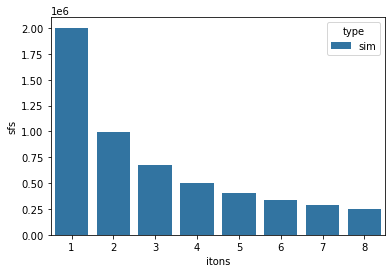

In [25]:
p = sns.barplot(data = sfs_sim_df, x='itons', y='sfs', hue= 'type')

<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b> What is the expected SFS for a neutrally evolving Wright-Fisher population (see mini lecture 2)? Define a list or array that gives this expectation for a sample of $n=9$ and store the result as a dataframe <code>sfs_exp_df</code> analogous to <code>sfs_sim_df</code>.
    </div>

In [22]:
#SOL

You can concatenate the simulated and expected SFS into a single dataframe and plot both using the code below:

In [ ]:
sfs_concat_df = pd.concat([sfs_sim_df, sfs_exp_df])
p = sns.barplot(x='itons', y='sfs', hue='type', data=sfs_concat_df)

<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b> What explains the difference between expected and observed SFS? Normalize both SFS by the total length of genealogical branches and replot! 
    
**Hint:** <code>sfs_mean/=np.sum(sfs_mean)</code> can be used to assign a normalized (by the total) sfs to the same variable name. Once you have normalized both SFSs, you need to define the dataframe <code>sfs_concat_df</code> again.
    </div>

In [9]:
#SOL

<div class="alert alert-block alert-success">    
    <b>Note:</b> You could measure how well your simulated SFS fits the expectation by cimputing the sum of squared differences. You can use the functions <code>np.sum()</code> and <code>np.square()</code>. Both are vectorized operations for numpy arrays, i.e. fact that <code>np.square()</code> applies  <code>**2 </code> to each element of the array.
    </div>

In [ ]:
diff_sfs=(sfs_sites_mean-sfs_exp);
np.sum(np.square(diff_sfs))

<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b> 
The code chunk below generates an expectation for the SFS based on mutation counts in 1,000 replicates (each 1kb of sequence) and a mutation rate of $\mu = 0.001$ as above. Store the new simulated SFS based on sites as a dataframe and add it to your existing SFS dataframe (using concatenate). Plot all three site frequency spectra. Which simulated SFS gives a closer fit to the analytic expectation? 
    </div>

In [26]:
sfs_sites_table = np.zeros((num_replicates, nsamp+1))
replicates = msprime.sim_ancestry(9, ploidy=1, num_replicates=num_replicates, sequence_length=1_000, random_seed=42)
for replicate_index, ts in enumerate(replicates):
    ts_with_muts = msprime.sim_mutations(ts, rate=0.001, random_seed = 34)
    sfs = ts_with_muts.allele_frequency_spectrum(polarised=True)
    sfs_sites_table[replicate_index] = sfs

sfs_sites_mean = sfs_sites_table.mean(0)[1:nsamp]
sfs_sites_mean /=np.sum(sfs_sites_mean)

In [33]:
type_sites = ['sites']*(nsamp-1)
sfs_sites_df = pd.DataFrame({'itons':itons,'sfs':sfs_sites_mean,'type':type_sites})

In [10]:
#SOL

## 2.2 The SFS of Sub-Saharan *Drosophila melanogaster*

Let's import an SFS from a real population (we will learn more about summarizing real sequence variation in practical 4)! For now, we will use an example from the king of all (lab) organisms: *D. melanogaster*.

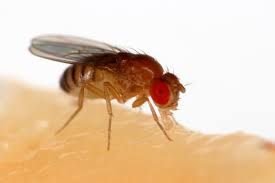

This [dataset](https://www.genetics.org/content/203/2/975) was generated from whole genome sequence (WGS) data from 17 haploid (**!!!**) *D. melanogaster* sequences sampled from Rwanda as part the Drosophila Population Genomics Project.

<div class="alert alert-block alert-warning">
    <b>Python recipe: data download using wget</b>
    
We can run any <code>bash</code> command from within a jupyter notebook by including `!` at the beginning of a code cell. To download a csv file containing the <i>D. melanogaster</i> sfs we will use <a href="https://g.co/kgs/VqTPwJ"><code>wget</code></a> (we will use <code>wget</code> to download data throughout the course): 
    </div>

In [27]:
! wget https://www.dropbox.com/s/xr56safng7hzs75/dmel_sfs.csv -q --show-progress -O dmel_sfs.csv
#--show-progress https://www.dropbox.com/s/xr56safng7hzs75/dmel_sfs.csv

dmel_sfs.csv        100%[===================>]     274  --.-KB/s    in 0s      


We can check that the file is in our working directory:

In [ ]:
! ls

In [ ]:
dmel_sfs = pd.read_csv('dmel_sfs.csv')
dmel_sfs

<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b> Check whether the <i>D. melanogaster</i> SFS is normalized. What is the total number of sites? Assign this to a new variable <code>n_dmel_total</code>. Are $0$ and $n$ entries for monomorphic and fixed sites included?
   </div>

In [11]:
#SOL

In [12]:
#SOL

It is helpful to give the variant only, normalized SFS a new variable name and store it as a dataframe. The code chunk below uses python indices and assign the SFS without the first and last entry to a new variable, defines an SFS that is normalized (by the total number of variable of sites) and stores this as a dataframe:

<div class="alert alert-block alert-info">
    <b>PopGen:</b> As in section 1 above, we will normalize the SFS by the total number of variable sites. In contrast, <code>msprime</code> normalizes by the total number of sites (i.e. the sequence length) by default.
    </div>

In [34]:
nsamp_dmel = 17
dmel_sfs_var = dmel_sfs['sfs'][1:nsamp_dmel]
dmel_sfs_var_norm = dmel_sfs_var/np.sum(dmel_sfs_var)
itons = range(1,nsamp_dmel)
type_dmel = ['dmel']*(nsamp_dmel-1)
sfs_dmel_df = pd.DataFrame({'itons':itons,'sfs':dmel_sfs_var_norm,'type':type_dmel})

<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b> Compare the <i>D. melanogaster</i> SFS to the neutral expectation for a sample from a Wright-Fisher population of constant size. Which entries show the greatest deviation from neutrality? What might be the cause?
    </div>

In [13]:
#SOL

<div class="alert alert-block alert-success">    
    <b>Exercise 12:</b>
Compute Watterson's $\theta$ (per base) for the <i>D. melanogaster</i> SFS (see lecture 2)

<b>Hint:</b> Use <code>exp_branches</code> defined above and  <code>n_dmel_total</code> (exercise 12).
    </div>

In [37]:
wattersons_correction17 = np.sum(exp_branches)
wattersons_correction17

3.3807289932289937

In [14]:
#SOL

<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b> Assume a mutation rate of $\mu= 3.5 \times 10^{-9}$ <a href="https://genome.cshlp.org/content/19/7/1195">(Keightley et al 2009)</a>. Translate your estimate of $\theta_W$ into the effective population size ($N_e$) for this species.
   </div>

In [15]:
#SOL

<div class="alert alert-block alert-info">
    <b>PopGen:</b> Remember that for a population of constant $N_e$, the frequency of singletons is also an estimator of the scaled mutation rate $\theta$ (see lecture 2).
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 14:</b> How does the estimate of $N_e$ based on singletons differ from the estimate based on $\theta_W$ above?
    </div>

In [16]:
#SOL

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

- What biological processes could explain the difference between the estimates of $N_e$ based on $\theta_w$ and the number of singleton mutations?
- What bioinformatic artefacts could generate an artefactual excess of singletons?
</div>

## 2.3 Fitting models of population growth and decline

There is an infinite number of possible models of population size change. A simple possibility (1 parameter) is to assume that the population size has been growing or shrinking deterministically: e.g. we could assume exponential growth. A more complex (2 parameter) model is a population change at some time $T$ in the past. The code chunk below defines a function that simulates a single genealogy from a population that has undegone exponential growth.

In [42]:
def run_growth_sims(num_samp, rate, num_rep=None, seed=123):    
    demography = msprime.Demography()
    demography.add_population(initial_size=1/2)
    demography.add_population_parameters_change(time=0, growth_rate= rate, population=0)
    return msprime.sim_ancestry(
        samples=[msprime.SampleSet(num_samp, ploidy=1)],
        num_replicates=num_rep,
        demography=demography,
        random_seed=seed)

<div class="alert alert-block alert-success">    
    <b>Exercise 15:</b> Use the function <code>run_growth_sims</code> to simulate a single genealogy for a sample of the same size as the <i>D. melanogaster</i> dataset. Assume a growth rate of 5 and use the <code>draw_svg</code> method to plot the resulting tree. How does this genealogy differ from the a genealogy sampled for a population of fixed size?
    </div>

Note that a growth rate of 5 is extreme population growth! Going back in time, the population size at time $T=0.5 \times 2N_e$ generations ago (1 million <i>D. melanogaster</i> generations) would be roughly an order of magnitude smaller than at present (time = 0):

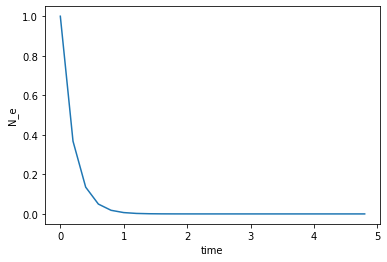

In [43]:
t = np.arange(0., 5., 0.2)
ty = np.exp(t*-5)
plt.ylabel('N_e')
plt.xlabel('time')
p = sns.lineplot(x =t, y =ty)

In [50]:
#SOL
ts_grow = run_growth_sims(17, rate=5, num_rep=None, seed=123)

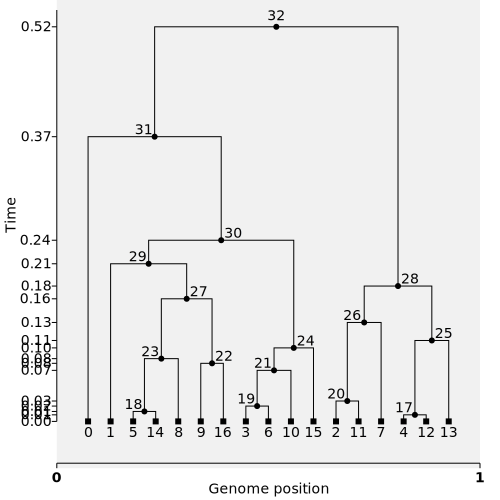

In [51]:
#SOL
display(SVG(ts_grow.draw_svg(size=(500, 500),y_axis=True)))

In [17]:
#SOL

<div class="alert alert-block alert-success">    
        <b>Exercise 16:</b> Use <code>run_growth_sims</code> to simulate the mean SFS for a population that has undergone exponential growth at rate 5. Does this history give a better fit to the Dmel history than a population of constant size?
    
<b>Hint:</b> Set <code>nsamp_dmel</code>
<code>growth_rate</code> and <code>num_replicates</code> in the code chunk below and run it to compute the mean across replicates as in section 2.1. Combine the dataframe with the Dmel SFS daraframe and plot.
</div>

In [141]:
nsamp_dmel = 17
growth_rate = 5
num_replicates = 10_000
sfs_table = np.zeros((num_replicates, nsamp_dmel+1))
replicates = run_growth_sims(nsamp_dmel, rate=growth_rate, num_rep=num_replicates)
for replicate_index, ts in enumerate(replicates):
    sfs = ts.allele_frequency_spectrum(mode="branch", polarised=True)
    sfs_table[replicate_index] = sfs

In [144]:
sfs_mean_g5 = sfs_table.mean(0)[1:nsamp_dmel]
sfs_mean_g5/=np.sum(sfs_mean_g5)

type_sim_g5 = ['sim_g5']*(nsamp_dmel-1)
sfs_sim_g5_df = pd.DataFrame({'itons':itons,'sfs':sfs_mean_g5,'type':type_sim_g5})

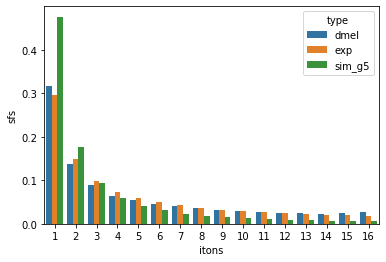

In [146]:
sfs_mean_g5 = sfs_table.mean(0)[1:nsamp_dmel]
sfs_mean_g5/=np.sum(sfs_mean_g5)

type_sim_g5 = ['sim_g5']*(nsamp_dmel-1)
sfs_sim_g5_df = pd.DataFrame({'itons':itons,'sfs':sfs_mean_g5,'type':type_sim_g5})

#Combines this with the dmel_SFS dataframe
sfs_dmel_concat3_df = pd.concat([sfs_dmel_concat_df, sfs_sim_g5_df])
p = sns.barplot(x='itons', y='sfs', hue='type', data=sfs_dmel_concat3_df)

## 2.4 Finding plausible demographic histories with Approximate Likelihood inference

Fitting real data to a model can be challenging. For very simple models, such a neutrally evolving Wright-Fisher population of constant size analytic expectations exist for summaries of sequence variation and one can use likelihood approaches maximise the fit between data and model. 

However, for most biologically interesting/realistic models analytic predictions do NOT exits. This has led to the development of likelihood-free inference methods, that use simulations to fit data to models of demographic history including Approximate Bayesian Computation (ABC) ([Beaumont 2002](https://www.genetics.org/content/162/4/2025)) and machine learning. 

We will demonstrate how `msprime` can be used for a simple approximate inference. Given the poor fit an exponential growth model when choosing an arbitrary growth rate (above), our aim is to infer the growth rate parameter that gives the best fit to the *D. melanogaster* SFS.

The code chunk below defines a function `approx_1DS_SFS` that sets up a number of replicate msprime simulations under an arbitrary demography and returns the mean SFS.

In [148]:
def approx_1D_SFS(num_samp, demography, num_rep=None, seed=123):
    sfs_table = np.zeros((num_rep, num_samp+1))
    replicates = msprime.sim_ancestry(
        samples=[msprime.SampleSet(num_samp, ploidy=1)],
        num_replicates=num_rep,
        demography=demography,
        random_seed=seed)
    for replicate_index, ts in enumerate(replicates):
        sfs = ts.allele_frequency_spectrum(mode="branch", polarised=True)
        sfs_table[replicate_index] = sfs
    sfs_mean = sfs_table.mean(0)[1:num_samp]
    return sfs_mean / np.sum(sfs_mean)

If we want to find the best fitting history, we need to compare the real data to simulations under a range of growth models. Let's define a numpy array of growth rates from 0 to 0.5: 

In [149]:
growth_rate_grid = np.arange(-0.02,0.5,0.01)

We can  use <code>approx_1D_SFS</code> to find the approximate SFS (based on 1,000 replicate simulations) for each value in <code>growth_rate_grid</code>:

In [150]:
num_rep = 1_000
sfs_exp_grid = np.zeros((len(growth_rate_grid), nsamp_dmel-1))
for rate_index, rate in enumerate(growth_rate_grid):
    demography = msprime.Demography()
    demography.add_population(initial_size=1/2)
    demography.add_population_parameters_change(time = 0, growth_rate = rate, population=0)
    sfs_exp_grid[rate_index] = approx_1D_SFS(num_samp = nsamp_dmel, demography = demography, num_rep = num_rep, seed=123)

<div class="alert alert-block alert-info">
    <b>PopGen:</b>

How do we compare the real and simulated SFS? There are two obvious options:
 - We could compute sum of squared differences, aka the Euclidean distance between the observed and simulated (mean) SFS. ABC inference is based on this measure of goodness of fit.
 - Alternatively, we can could compute a likelihood. Remember that the normalised SFS can be interpreted as a probability distribution; i.e. each entry gives the probability of the correspoding $n_{ton}$ type. The overal log likelihood (support) of the model ($\Theta$) given a set of SFS counts $\bar{j} = \{j_1, j_2 \ldots j_{n-1}\}$ is:

\begin{equation}
ln(L[\Theta |\bar{j}]) = \sum_{i=1}^{n-1} j_i \times ln(p_i)
\end{equation}
 </div>

In [151]:
support = np.zeros(len(growth_rate_grid))
for idx, sfs in enumerate(sfs_exp_grid):
    support[idx] = sum(np.log(sfs) * dmel_sfs_var)

In [ ]:
plt.xlabel('growth_rate')
plt.ylabel('support (lnL)')
p = sns.lineplot(x = growth_rate_grid, y = support)

<div class="alert alert-block alert-success">    
    <b>Exercise 17:</b> How do you interpret the support curve above? 
    </div>

The code chunk below sets up an instantaneous bottleneck at time $t=0.2$ (on the coalescence scale of 2 $N_e$ generations) will be useful. To keep things simple, we will keep the bottleneck time fixed (at 0.2) and explore strengths between 0 and 11.

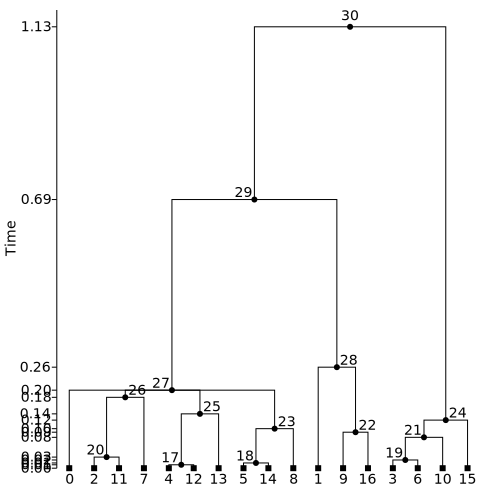

In [153]:
demography = msprime.Demography()
demography.add_population(initial_size=1/2)
demography.add_instantaneous_bottleneck(time=0.2, strength=0.2, population=0)
bottle_ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(nsamp_dmel, ploidy=1)],
        demography=demography,
        random_seed=123)
bottle_tree = bottle_ts.first()
display(SVG(bottle_tree.draw_svg(size=(500, 500),y_axis=True)))

This sets up an empty 2D array and <code>sfs_bott_grid</code> and stores the simulated SFS for each bottleneck strength: 

In [154]:
num_rep = 5_000
num_samp = 17
bott_grid = np.arange(0,1,0.05)
sfs_bott_grid = np.zeros((len(bott_grid), num_samp-1))
for strength_index, strength in enumerate(bott_grid):
    demography = msprime.Demography()
    demography.add_population(initial_size=1/2)
    demography.add_instantaneous_bottleneck(time=0.2, strength=strength , population=0)   
    sfs_bott_grid[strength_index] = approx_1D_SFS(num_samp = num_samp, demography = demography, num_rep = num_rep)

<div class="alert alert-block alert-success">    
    <b>Exercise 18:</b> The code below computes the approximate likelihood for each bottleneck strength parameter and plots it! Which history best fits the data (and which entry in <code>sfs_bott_grid</code> corresponds to it)?
        </div>

In [155]:
support_bott = np.zeros(len(bott_grid))
for idx, sfs in enumerate(sfs_bott_grid):
    support_bott[idx] = sum(np.log(sfs) * dmel_sfs_var)

In [ ]:
plt.xlabel('bottleneck strength')
plt.ylabel('support (lnL)')
p = sns.lineplot(x = bott_grid, y = support_bott)

<div class="alert alert-block alert-success">    
    <b>Exercise 19:</b> Compare the SFS under the best fitting bottleneck history to both the observed and the neutral SFS. Check whether low or high frequency mutations (or both) is better predicted under this model. Do you think this model is biologically plausible for Sub-Saharan African populations of <i>D. melanogaster</i>?
    </div>

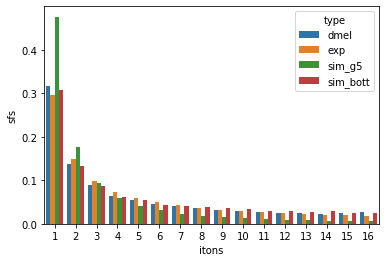

In [157]:
type_sim_bott = ['sim_bott']*(nsamp_dmel-1)
sfs_sim_best_bottle_df = pd.DataFrame({'itons':itons,'sfs':sfs_bott_grid[7],'type':type_sim_bott})
#Combines it with the dmel_SFS dataframe
sfs_dmel_concat4_df = pd.concat([sfs_dmel_concat3_df,sfs_sim_best_bottle_df])
p = sns.barplot(x='itons', y='sfs', hue='type', data=sfs_dmel_concat4_df)